In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels as sm
from statsmodels.stats import proportion
import warnings
from tqdm import tqdm
%matplotlib inline

In [2]:
# my package, name to be changed:
import local_connectivity
from local_connectivity import make_tables, dist, connect_stats, plot
%reload_ext autoreload
%autoreload 2

### Careful! Read https://annotationframeworkclient.readthedocs.io/en/stable/guide/authentication.html#new-token if this does not work for you!

In [3]:
client = CAVEclient(global_only=True)
client = CAVEclient('minnie65_phase3_v1')

In [4]:
# using this as the only place to pull pre-syn's from because it's well-proofread
presyn_df = ['allen_v1_column_types_slanted']
df = client.materialize.query_table(presyn_df[0],split_positions=True)

/usr/local/Caskroom/miniconda/base/envs/brain/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


Put your pre-synaptic root_id's here...

In [5]:
pre_root_ids = [864691135428608048]
pre = []
for i in range(len(pre_root_ids)):
    pre_grab = df.query(f"pt_root_id == @pre_root_ids[{i}]")
    pre.append(pre_grab)
len(pre)

1

Or grab from the proofread df!

In [6]:
np.unique(df.cell_type)

array(['23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6IT', '6P', 'BC',
       'BPC', 'MC', 'NGC', 'Unsure'], dtype=object)

In [7]:
pre_23P = []
pre_df = df.query("cell_type == '23P'").reset_index(drop=True)
for i in range(len(pre_df)):
    p = pre_df.iloc[[i]]
    pre_23P.append(p)
len(pre_23P)

347

The following function, `build_tables`, takes only 1 input, and that is one pre-synaptic cell. The function outputs 3 things, all pandas tables containing confirmed single-body somas that have been analyzed by Forrest & Leila and categorized as 1 out of 11 possible subtypes: 

1. `main` table containing all of the above,
2. `syn` table containing only neurons connecting to whichever pre-synaptic cell was given,
3. `nonsyn` table containing only neurons that are NOT connected to the pre-synaptic cell.

All three have their positions split into x,y,z and all have columns corresponding to their Euchlidean and Radial distance from the pre-synaptic cell. In the main table, if their `pre_pt_root_id` equals zero, that means they are not in the post-synaptic table, and not connected to the pre-synaptic root_id.

In [8]:
main,syn,nonsyn = [],[],[]
badroots = []
for i in tqdm(range(len(pre))):
    try:
        m,s,n = make_tables.build_tables(client,pre[i])
        main.append(m)
        syn.append(s)
        nonsyn.append(n)
    except:
        badroots.append(pre[i])
        continue

  0%|                                                     | 0/1 [00:00<?, ?it/s]/var/folders/nm/l50fqsn14416wyl0lh09ckb40000gn/T/ipykernel_66754/1780857866.py:5: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  m,s,n = make_tables.build_tables(client,pre[i])
100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


In [9]:
for j in range(len(pre)):
    print("There are {0:d} neuronal post-synaptic connections for cell {1:d}!".format(len(syn[j]),int(pre[j].pt_root_id)))

There are 1723 neuronal post-synaptic connections for cell 864691135428608048!


The following functions will take the tables generated above and split them into class-specific or type-specific tables. 

 - `r_interval` is the bin width for each radial ring (in microns)
 - `up`, again in microns, is the upper (radial) distance limit away from your pre-synaptic cell
 - `threshold` in microns is the distance away at least one of the synapses needs to be from the target cell's soma
 

The tables will be referenced as such: 

- `main_class[0]` will contain two class-specific tables for your first pre-synaptic root_id
- `syn_types[1][3]` will contain a single table of cells of the fourth specific type for your second pre-synaptic root_id, and only contain the ones connected to your pre-syn cell
- `f_type` contains the number of cells per bin not connected (failure) within the radial distance bin, and 
- `s_type` contains the number of cells per bin that IS connected (success) with that bin

In [10]:
r_interval = 25
up = 200
threshold = 40
main_types,syn_types,nonsyn_types,f_type,s_type = make_tables.final_prep(main,syn,nonsyn,r_interval,up,threshold=None)
main_thresh,syn_thresh,nonsyn_thresh,main_types_thresh,syn_types_thresh,nonsyn_types_thresh,f_type_thresh,s_type_thresh = make_tables.final_prep(main,syn,nonsyn,r_interval,up,threshold)

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/it]


Finally, this cell will create a pdf of the 33-panel plot for each pre-synaptic root_id inside of the table `pre`. Arguments are as follows:
1. `client` defined at the start
2. `pre` is the pre-synaptic table (just one row)
3. `main` is the entire table
4. `syn_types` is the synaptic table split into types
5. `nonsyn_types` is the non-synaptic table, also split into types
6. `s_type` is any array containing the number of successful connections to single somas per radial distance bin, generated above.
7. `f_type` is any array containing the number of unconnected cells per radial distance bin, generated above.
8. `r_interval` is the number of microns in a bin interval, depending on how it was defined in a previous cell
9. `upper_distance_limit` defined in a previous cell,
10. `threshold` was also defined previously. threshold=None will run far faster than threshold=0.

In [11]:
plot.makepdfs(client,pre,main,syn_types,nonsyn_types,s_type,f_type,r_interval,up,None)
plot.makepdfs(client,pre,main,syn_types_thresh,nonsyn_types,s_type_thresh,f_type_thresh,r_interval,up,threshold)

  0%|                                                     | 0/1 [00:00<?, ?it/s]/var/folders/nm/l50fqsn14416wyl0lh09ckb40000gn/T/ipykernel_66754/865974846.py:1: FutureWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  plot.makepdfs(client,pre,main,syn_types,nonsyn_types,s_type,f_type,r_interval,up,None)
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


For displaying in the notebook, you can use this:

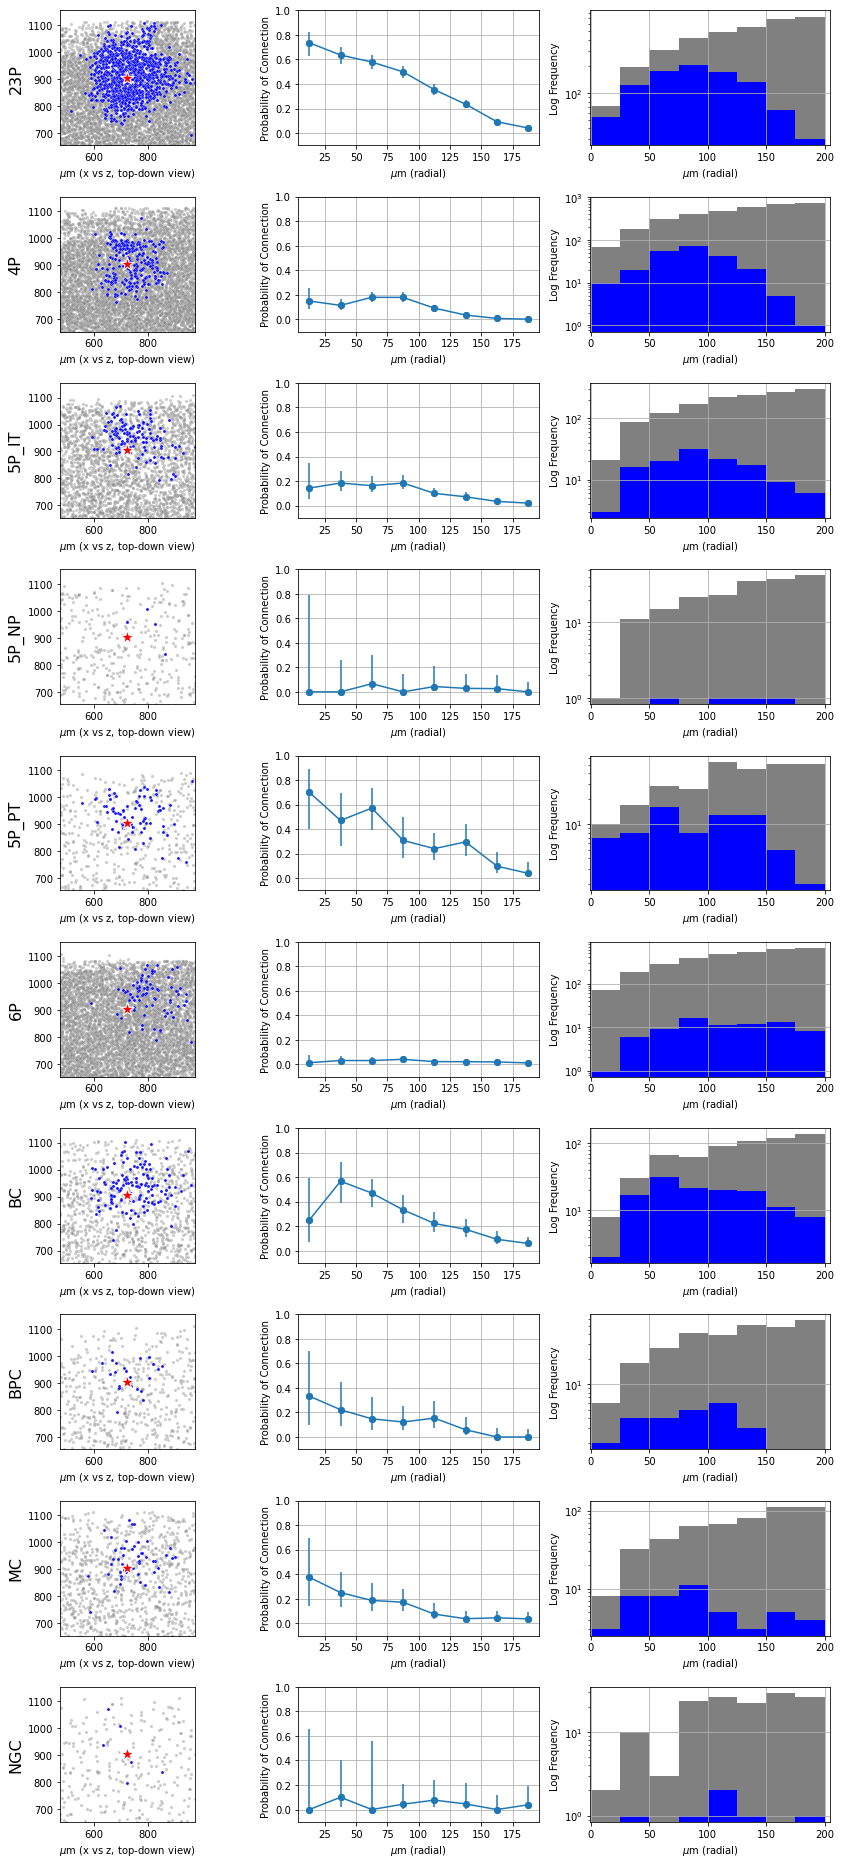

In [13]:
filename = 'NotNeeded'
plot.threepanels_pertype(main[0],pre[0],syn_types[0],nonsyn_types[0],s_type[0],f_type[0],r_interval,up,filename,display=True)